<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Logistic_regression_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `Logistic Regression`
---

A logistic regression model applies the sigmoid to the familiar linear regression model as shown below:

$f(x) = \frac{1}{1 + e^{\beta_0 + \sum _{j=1}^{p} X_j\beta_j}}$

**where**
- $f(x)$: response/dependent variable
- $X_j$: explanatory/independent variable
- $\beta_j$: slope coefficient
- $\beta_0$: intercept terms

We interpret the output of the model $f(x)$ as the probability that $y = 1$ given $x$ and parameterized by $\beta_0$ and $\beta_j$. Therefore, to get a final prediction ($y = 0$ or $y = 1$) from the logistic regression model, we can use the following heuristic:

- if $f(x) >= 0.5$, predict $y = 1$
- if $f(x) < 0.5$, predict $y = 0$

**Importing Libraries**

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

### `Business Problem Understanding`

**Problem Statement**
Wine quality classification is a challenging task because taste is the least understood by the human senses. Good wine quality prediction can be very useful in the certification stage, as currently, sensory analysis is performed by humans through tasting, which is a subjective approach.

**Goals**
Determine wine quality based on alcohol and density.

**Analytic Approach**
So, what we need to do is analyze the data to find patterns in the existing features that differentiate one wine from another.

Next, we will build a classification model that will help companies provide quality prediction tools for new wines, which will be useful for determining wine prices.

**Metric Evaluation**
The evaluation metric used is accuracy. The higher the value, the more accurate the model is in labeling wine quality according to the limitations of the features used.

### `Data Understanding`

In [2]:
white_wine_csv = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/white_wine.csv'
data = pd.read_csv(white_wine_csv)[['alcohol', 'density', 'quality']]
data.head()

,alcohol,density,quality
0,8.8,1.0010,6.0
1,9.5,0.9940,6.0
2,10.1,0.9951,6.0
3,9.9,0.9956,6.0
4,9.9,0.9956,6.0


In [3]:
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'min': data.min().values,
    'max': data.max().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,min,max,sample_unique
0,alcohol,float64,0.192308,False,45,8.5000,12.9000,"[8.8, 9.5, 10.1, 9.9, 9.6, 11.0, 12.0, 9.7, 10..."
1,density,float64,0.000000,False,100,0.9899,1.0033,"[1.001, 0.994, 0.9951, 0.9956, 0.9949, 0.9938,..."
2,quality,float64,0.192308,False,6,3.0000,8.0000,"[6.0, 5.0, 7.0, 8.0, 4.0, 3.0, nan]"


**Insight**

- The dataset consists of 520 rows and 12 columns.
- All variables are numeric and continuous, except for quality, which is discrete.
- The data format for the quality variable should be integer.
- The scale of the total sulfur dioxide and free sulfur dioxide variables is larger than the others.

### `Data Preparation`

`Duplicates`

In [4]:
print(f'Number of duplicate data {data.duplicated().sum()}')
print(f'Percentage of duplicate data {data.duplicated().sum()/len(data)*100:.2f}%')

Number of duplicate data 115
Percentage of duplicate data 22.12%


As much as 22% of the data is indicated as duplicate, so remove one of them.

Handling duplicated data

In [5]:
data.drop_duplicates(inplace=True, ignore_index=True)

`Missing Values`

In [8]:
data.isna().sum().to_frame('missing_values')

,missing_values
alcohol,1
density,0
quality,1


Two variables (alcohol, quality) contain 1 data point or 0.2% missing value.

Handling missing value:

In [9]:
data.dropna(inplace=True)

`Rare Labels`

In [10]:
data['quality'].value_counts(normalize=True)*100

,proportion
quality,
6.0,45.049505
5.0,31.435644
7.0,15.099010
4.0,4.207921
8.0,3.217822
3.0,0.990099


More than 50% is dominated by wines with a quality of more than 6. The best wine is class 10, while the worst is class 1.

Handling rare value

In [11]:
import numpy as np

data['quality'] = np.where(data['quality']>6, 1, 0)

`Outliers`

Detecting outliers

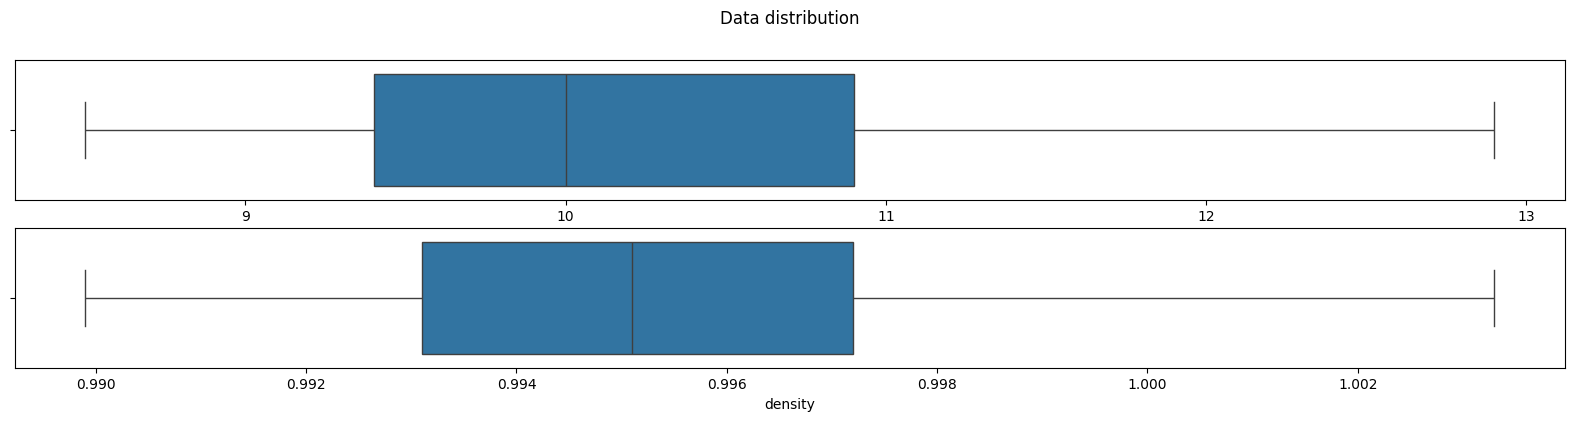

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20,4))

sns.boxplot(data=data, x='alcohol', ax=ax[0])
sns.boxplot(data=data, x='density', ax=ax[1])

ax[0].set_title('Data distribution', y=1.2)
plt.show()


There are no outliers in the alcohol and density variables.

`Imbalance Data`

Detection and quantification of target label proportion

In [13]:
data['quality'].value_counts(normalize=True).to_frame()

,proportion
quality,
0,0.816832
1,0.183168


The percentage of label 0 (81.6%) is more than label 1 (18.2%), this includes imbalance.

The data is imbalanced because there are more negative than positive data.

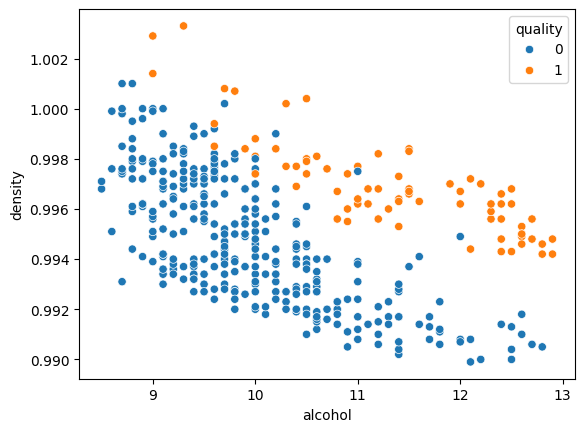

In [14]:
sns.scatterplot(data=data, x='alcohol', y='density', hue ='quality')
plt.show()

`Check Multicollinearity`

Detecting multicollinearity between features with VIF.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# define feature and target
X = data.drop(columns=['quality'])
y = data['quality']

vif = pd.DataFrame()
vif['VIF factor'] = [variance_inflation_factor(X.values, 1) for i in range(X.shape[1])]
vif['feature'] = X.columns

vif.round(2)



,VIF factor,feature
0,88.56,alcohol
1,88.56,density


There is multicollinearity between the alcohol and density features. When using a linear model, multicollinearity should be avoided. However, for this case study, we will maintain this.

**Feature Engineering**

Split the dataset into a train and test set.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

X_train.shape, X_test.shape


((323, 2), (81, 2))

In [17]:
# Proportion on y
y.value_counts(normalize=True)

,proportion
quality,
0,0.816832
1,0.183168


In [18]:
# Proportion on y_train
y_train.value_counts(normalize=True)

,proportion
quality,
0,0.817337
1,0.182663


In [19]:
# Proportion on y_test
y_test.value_counts(normalize=True)

,proportion
quality,
0,0.814815
1,0.185185


### `Model Experiment`

In [20]:
import statsmodels.api as sm

logreg = sm.Logit(y_train, sm.add_constant(X_train))
result = logreg.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.093277
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                quality   No. Observations:                  323
Model:                          Logit   Df Residuals:                      320
Method:                           MLE   Df Model:                            2
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.8038
Time:                        07:39:44   Log-Likelihood:                -30.128
converged:                       True   LL-Null:                       -153.56
Covariance Type:            nonrobust   LLR p-value:                 2.488e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2239.0362    405.881     -5.516      0.000   -3034.549   -1443.524
alcohol        5.4321      0

p>z (wald test) is significant - less than 0.05 - it does require alcohol

**Estimating Coefficients**

**P>|z| (Wald Test)**

- **const** = 0.000. pvalue < 0.05, reject Ho. That is, the model requires an intercept value.
- **alcohol** = 0.000. pvalue < 0.05, reject Ho. This means that alcohol has a significant negative effect on quality (the larger the alcohol, the larger the quality)
- **density** = 0.000. pvalue < 0.05, reject Ho. This means that density has a significant negative effect on quality (the larger the density, the larger the quality)

**Odd Ratio (OR)**

In [21]:
X_train.describe().loc[['min', 'max']]

,alcohol,density
min,8.5,0.9899
max,12.9,1.0033


`Alcohol`

In [22]:
beta = 5.4321 # Beta is the coefficient of alcohol
c = 9.1 # This range in the data is between 8.5 - 12.9
d = 9 # This value should be smaller than the c value

OR_alcohol = np.exp(beta*(c-d))
OR_alcohol # odds ratio

np.float64(1.7215240946330392)

- Probability of good quality increases when alcohol increases
- Wine with alcohol 9.1 has about 1.72 times more likely to be good quality than wine with alcohol 9.

`Density`

In [23]:
beta = 2188.5305 # Beta is the density coefficient
c = 0.992 # This range in the data is between 0.9899 - 1.0033
d = 0.991 # This value should be smaller than the c value

OR_density = np.exp(beta*(c-d))
OR_density # odds ratio

np.float64(8.922092461787537)

- Probability of good quality increases when density increases
- Wine with a density of 0.992 has about 8.2 times more likely to be good quality than wine with a density of 0.991.

**Evaluating the Model**

In [24]:
print(result.summary().tables[0])

                           Logit Regression Results                           
Dep. Variable:                quality   No. Observations:                  323
Model:                          Logit   Df Residuals:                      320
Method:                           MLE   Df Model:                            2
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.8038
Time:                        07:46:04   Log-Likelihood:                -30.128
converged:                       True   LL-Null:                       -153.56
Covariance Type:            nonrobust   LLR p-value:                 2.488e-54


**Log Likelihood Ratio (LLR) Test**

- `Ho`: $\beta_1$ = $\beta_2$ = $\beta_3$ = $\beta_4$ = ..... = 0
- `Ha` : Not all coefficient ($\beta_i$) are 0 (there is at least 1 feature whose value ($\beta_i$) is not 0)
- $\alpha$: 0.05
- `LLR p-value` = 2.488e-54 < 0.05, reject Ho. We have enough evidence that density or alcohol affects the wine quality.


**Accuracy**

In [25]:
result.params

,0
const,-2239.036223
alcohol,5.432143
density,2188.530480


In [26]:
X_test.loc[396]

,396
alcohol,10.0000
density,0.9921


In [27]:
y_pred_proba = result.predict(sm.add_constant(X_test)) # probability prediction
y_pred_proba.head()

,0
396,0.000001
206,0.003451
89,0.000027
140,0.000044
235,0.060092


In [28]:
y_pred_class = np.where(y_pred_proba > 0.5, 1, 0)
y_pred_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [29]:
from sklearn.metrics import accuracy_score

print(f'Model accuracy on dataset: {accuracy_score(y_test, y_pred_class)}')
print(f'From {len(y_test)} wine bottles, {accuracy_score(y_test, y_pred_class) * len(y_test)} bottles are predicted correctly')

Model accuracy on dataset: 0.9753086419753086
From 81 wine bottles, 79.0 bottles are predicted correctly


**Predict to New Data**

In [30]:
X.describe().loc[['min', 'max']]

,alcohol,density
min,8.5,0.9899
max,12.9,1.0033


In [31]:
new_data = pd.DataFrame({
    'alcohol': [9,10,11],
    'density': [0.99, 0.995, 10]
})

In [32]:
result.predict(sm.add_constant(new_data)).round(2)

,0
0,0.0
1,0.0
2,1.0
